In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils.multiclass import unique_labels

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
#Import standard libraries

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
''' to learn more about itertools visit
    https://medium.com/@jasonrigden/a-guide-to-python-itertools-82e5a306cdf8'''
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
#Import keras functions

from keras import Sequential

'''Since we are using transfer learning let's import the model that we want to implement.Let's use VGG 19(19 layers) and Resnet-50 (50 layers of residual units). 
Residual units allow us to add more layers onto the model without a degradation in accuracy.
Let's try and compare the accuracy of the 2 models and see if the addtional layers do make a significant difference. '''

from keras.applications import VGG19,ResNet50

'Import the datagenerator to augment images'
from keras.preprocessing.image import ImageDataGenerator

'''Import the optimizers and leanring rate annealer (which will reduce the learning rate once a particular metric we choose(in this case validation error) 
does not reduce after a user defined number of epochs)'''
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau

'Lastly import the final layers that will be added on top of the base model'
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout

'Import to_categorical from the keras utils package to one hot encode the labels'
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
#Import dataset
from keras.datasets import cifar10

In [5]:
#Divide the data in Train, Validation and Test Datasets
'I had to turn the Internet setting to on to download load the dataset'
(x_train,y_train),(x_test,y_test)=cifar10.load_data()



170500096/170498071 [==============================] - 32s 0us/step


In [6]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [7]:
#Print the dimensions of the datasets to make sure everything's kosher

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [8]:
#One hot encode the labels.Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)


In [9]:
# Lets print the dimensions one more time to see if things changed the way we expected

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


We can now begin the actual process of model building.I find that following a set process and following consistently makes learning this easier.So here is the process I follow:

*  Define the Data Augmentation (ImageDataGenerator) and Learning Rate Annealer (ReduceOnPlateau) functions
*  Build the model (Base Model + Flatten + Dense)
*  Check model summary
*  Initialize Batch Size,Number of Epochs
*  Compile model
*  Fit the model (We will use fit_generator since the data is fed to the model using an augmentation function
*  Evaluate the model on test data


In [10]:
#Data Augmentation Function: Let's define an instance of the ImageDataGenerator class and set the parameters.We have to instantiate for the Train,Validation and Test datasets
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 




In [11]:
#Fit the augmentation method to the data

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

It's not necessary to use a data generator for validation data while fitting the model, however I find that it gives better validation accuracy if it is used.This is probably because themodel can learn more generalized features if validation data is also augmented.
Ive used only a few of the many available functionalities of the augment function.To know more about the capabilities read this article:
https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085


In [12]:
'''Learning Rate Annealer: The learning rate can be modified after a set number of epochs or after a certain condition is met. We will use the latter and change the learning rate if 
the validation error does not reduce after a set number of epochs. To do this we will use the patience parameter.'''

lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

In [13]:
#Build the model

'The first base model used is VGG19. The pretrained weights from the imagenet challenge are used'
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

'For the 2nd base model we will use Resnet 50 and compare the performance against the previous one.The hypothesis is that Resnet 50 should perform better because of its deeper architecture'
base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step


/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [14]:
#Lets add the final layers to these base models where the actual classification is done in the dense layers

model_1= Sequential()
model_1.add(base_model_1) #Adds the base model (in this case vgg19 to model_1)
model_1.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers


Before we add the dense layers we must know the shape of the output of the flatten layer so we can define the input shape to the dense layer accordingly. The way I handle is I print the summary of the model after the flatten layer is added. 

In [15]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


So after the flatten layer we see the output to be a vector of (512,1).This will help in deciding the number of neurons in the dense layer following the flatten layer.

In [16]:
#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(Dense(512,activation=('relu'))) 
model_1.add(Dense(256,activation=('relu'))) 
#model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_1.add(Dense(128,activation=('relu')))
#model_1.add(Dropout(.2))
model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer


In [17]:
#Check final model summary
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total para

After checking the model summary, let's initialize the batchsize and number of epochs.You can leave the batch unspecified and it defaults to 32. Batch size is the number of samples over which the gradient is calculated. An epoch is just the number of times the entire dateset is passed through the network.

As a rule of thumb, as the batch size increases, the accuracy over each epoch SHOULD increase faster than if the batch size were smaller. This makes sense since we are training the model over more samples over each step. Therefore the number of epochs required to converge to a solution SHOULD THEORETICALLY be less. 

A lot of selection parameters have to do with the size and shape of training data. Since our training data set has 35K samples, we can choose a larger batch size.

In [18]:
batch_size= 100
epochs=50

The next step is to define the learning rate for the optimizer we will use. I have chosen the SGD and Adam optimizer. The main difference between the 2 is that SGD uses the same learning rate for all parameters and updates all of them by the same amount. The learning rate does not change during training. Adam stands for Adaptive Moment estimation and maintains a separate learning rate for each parameter and updates them separately.

To understand this concept more please read this article:
https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

In [19]:
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


This is the official Keras documentation page on Optimizers.Since the choice o optimizer has a lot of influence on model performance, I'd reccomend giving it a read

* https://keras.io/optimizers/

In [20]:
#Compile the model
#During model compiling the 3 main things we specify are loss function,optimizer and the metrics that need to be evaluated during the test and train processes.
#Lets start by using the SGD optimizer
#We will specify the loss as categoricl crossentropy since the labels are 1 hot encoded. IF we had integer labels,we'd have to use sparse categorical crossentropy as loss function.
model_1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])


Now comes the fun part: Model Training. Since we're using a function to generate data, we have to use the argument fit_generator. Both the train data and the validation data will be generated using the augmentation methods we have previously defined. To use the fit_generator function we will define the following parameters:

generator.flow(x_train,y_train,batch_size)

Here we use generator.flow since the data is being generated from a numpy array. You could also have data available in folders in which case we would use flow_from_directory in which case the class names are inferred directly from the folder names within the train data folder

More information on this can be found by reading the official documentation:
https://keras.io/preprocessing/image/



In [21]:
model_1.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
350/350 [==============================] - 38s 110ms/step - loss: 2.0637 - acc: 0.2060 - val_loss: 1.6165 - val_acc: 0.3947
Epoch 2/50
350/350 [==============================] - 33s 95ms/step - loss: 1.1819 - acc: 0.5698 - val_loss: 0.9478 - val_acc: 0.6733
Epoch 3/50
350/350 [==============================] - 34s 98ms/step - loss: 0.8292 - acc: 0.7155 - val_loss: 0.7701 - val_acc: 0.7371
Epoch 4/50
350/350 [==============================] - 35s 100ms/step - loss: 0.6818 - acc: 0.7675 - val_loss: 0.6621 - val_acc: 0.7718
Epoch 5/50
350/350 [==============================] - 35s 99ms/step - loss: 0.5913 - acc: 0.7982 - val_loss: 0.6721 - val_acc: 0.7702
Epoch 6/50
350/350 [==============================] - 35s 100ms/step - loss: 0.5259 - acc: 0.8193 - val_loss: 0.5923 - val_acc: 0.8014
Epoch 7/50
350/350 [==============================] - 35s 100ms/step - loss: 0.4765 - acc: 0.8358 - val_loss: 0.6386 - val_acc: 0.7881
Epoch 8/50

1. Let's now begin to evaluate our model.

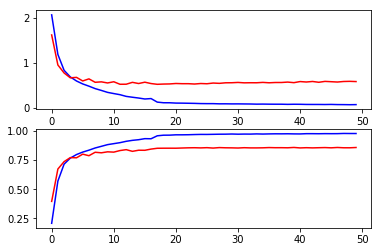

In [22]:
#Plot the training and valiation loss
'''The output of model.fit is a model.History object which is a record of metrics at each epoch. This can be used to graph the training and validation accuracy
to see where they plateaued off and if overfitting can subsequently be avoided'''

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(model_1.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model_1.history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(model_1.history.history['acc'],color='b',label='Training  Accuracy')
ax[1].plot(model_1.history.history['val_acc'],color='r',label='Validation Accuracy')

From the figures it is evident that we could have run the model to 4 or 5 epochs. 

The next step in model evaluation is building the confusion matrix. The following code is from the official documentation of the sklearn library. 
It allows us to print a confusion matrix with labels and gives a choice of normalization. Id prefer to normalize since it'll give you the true positive percentage upfront
which is far better than absolute numbers if we are going to comapre models

https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py


In [23]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Now that we have our code for the confusion matrix, let's make predictions on the test set and see how this model has performed

In [24]:
y_pred=model_1.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)


In [25]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Confusion matrix, without normalization


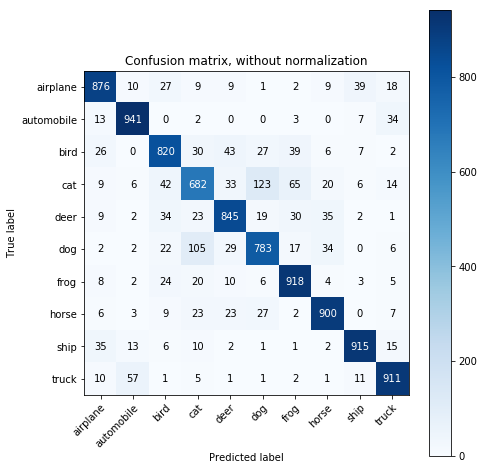

In [26]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')


Normalized confusion matrix


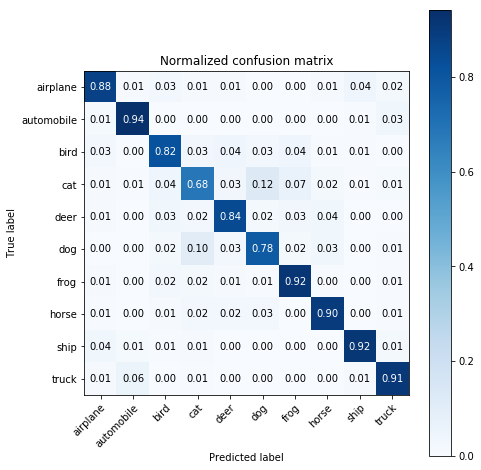

In [27]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
# plt.show()

Analysis Of Results: 
Looking at the Normalized Confusion Matrix, we see that overall, the model has performed well, except in the case of cats. The model seems to misclassify cats and dogs with each other.

To compare this with another model, let's try and use Resnet-50. Residual nets allow us to add deeper layers to the network, without having the problem of accuracy degradation. They do this by using skip connections, meaning they jump over layers.

To understand Resnets better please read the following links:

https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff

https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

In [28]:
#Since we have already defined Resnet50 as base_model_2, let us build the sequential model.

model_2=Sequential()
#Add the Dense layers along with activation and batch normalization
model_2.add(base_model_2)
model_2.add(Flatten())


#Add the Dense layers along with activation and batch normalization
model_2.add(Dense(4000,activation=('relu'),input_dim=512))
model_2.add(Dense(2000,activation=('relu'))) 
model_2.add(Dropout(.4))
model_2.add(Dense(1000,activation=('relu'))) 
model_2.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_2.add(Dense(500,activation=('relu')))
model_2.add(Dropout(.2))
model_2.add(Dense(10,activation=('softmax'))) #This is the classification layer

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [29]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 4000)              8196000   
_________________________________________________________________
dense_7 (Dense)              (None, 2000)              8002000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
__________

Immediately the first differences we see are that ResNet50 has a little more than 16 million extra parameters to train which is to be expected since it is a deeper model. Also, the number of units before the Flatten layer are 4 times that of the previous model.

In [30]:
#Compile the model 

model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
model_2.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                     epochs=100,steps_per_epoch=x_train.shape[0]//batch_size,
                     validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)

Epoch 1/100
350/350 [==============================] - 69s 197ms/step - loss: 2.1012 - acc: 0.2195 - val_loss: 4.5183 - val_acc: 0.1462
Epoch 2/100
350/350 [==============================] - 53s 151ms/step - loss: 2.0171 - acc: 0.2341 - val_loss: 1.8946 - val_acc: 0.2542
Epoch 3/100
350/350 [==============================] - 53s 152ms/step - loss: 1.7884 - acc: 0.2805 - val_loss: 1.7594 - val_acc: 0.3014
Epoch 4/100
350/350 [==============================] - 53s 151ms/step - loss: 1.6972 - acc: 0.3182 - val_loss: 1.7174 - val_acc: 0.3584
Epoch 5/100
350/350 [==============================] - 53s 151ms/step - loss: 1.5909 - acc: 0.3932 - val_loss: 1.6344 - val_acc: 0.4419
Epoch 6/100
350/350 [==============================] - 53s 152ms/step - loss: 1.4676 - acc: 0.4628 - val_loss: 1.8102 - val_acc: 0.4141
Epoch 7/100
350/350 [==============================] - 53s 152ms/step - loss: 1.3484 - acc: 0.5176 - val_loss: 1.7752 - val_acc: 0.4261
Epoch 8/100
350/350 [===========================

The validation accuracy has stabalized at around 75%. Let's plot the Training Vs Validation losses and accuracy to see if overfitting has occured.


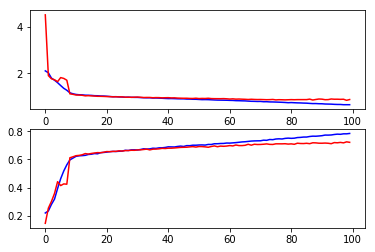

In [32]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(model_2.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model_2.history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(model_2.history.history['acc'],color='b',label='Training  Accuracy')
ax[1].plot(model_2.history.history['val_acc'],color='r',label='Validation Accuracy')

This model starts overfitting at around 80 epochs where we find that the validation accuracy stays the same, however the training accuracy keeps increasing. The validation accuracy at this point is around 74%.Compared to the previous model, this model's performance is not that good. At the point of overfitting the previous model had a validation accuracy of 78%. IF this hypothesis is true, then we should see the result in the confusion matrix. So let us plot those now 

In [33]:
y_pred_resnet=model_2.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred_resnet)

Confusion matrix, without normalization


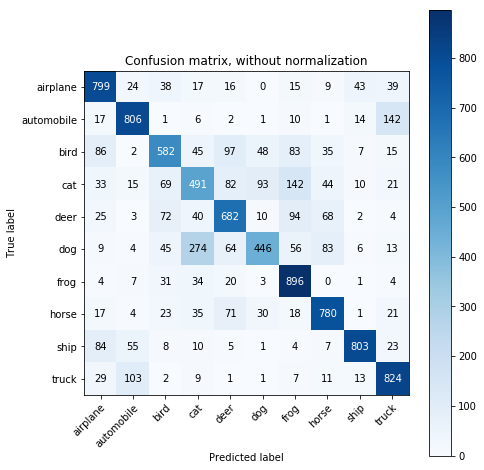

In [34]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_resnet, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


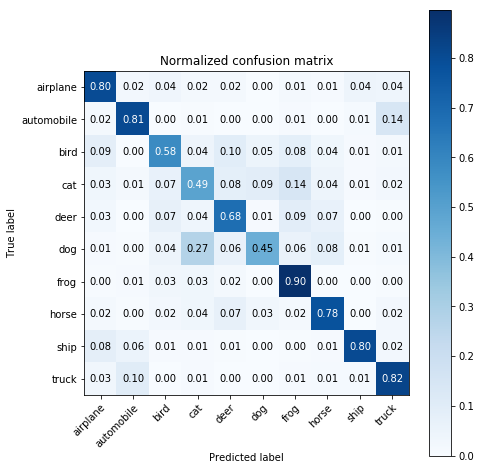

In [35]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_resnet, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
# plt.show()

The comparison of the normalized matrices clearly shows that the First model (VGG 19) works better for this dataset. This could probably be because the images are only 32X32 pixels. For a resolution this low,perhaps the resnet model is overkill. To make sure, feel free to download the notebook and play with the hyperparameters. Good luck and happy learning!